<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Krista_Shepard_DS5_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [3]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [4]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=577.0842351059626, mobile=False), User(purchased=True, time_on_site=437.757417446246, mobile=False), User(purchased=False, time_on_site=190.50116804515488, mobile=True), User(purchased=False, time_on_site=238.23767475196684, mobile=True), User(purchased=False, time_on_site=91.55561048394017, mobile=True), User(purchased=False, time_on_site=226.82770701802286, mobile=True), User(purchased=False, time_on_site=62.51545990146557, mobile=True), User(purchased=False, time_on_site=78.98320824661377, mobile=True), User(purchased=False, time_on_site=287.30365951707915, mobile=False), User(purchased=False, time_on_site=550.2818297382013, mobile=False)]


In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,577.084235,False
1,True,437.757417,False
2,False,190.501168,True
3,False,238.237675,True
4,False,91.555610,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.0687264376376655,5.5450285627987865,5.622602057529046,5.724490814855951,6.225737946706218,6.73615260582343,7.097968380399662,7.115589680661886,7.543923157815317,8.230919416558072,8.654538329777154,9.5274497939653,9.682317056832737,9.827045869482124,10.34277420534745,10.557959398900223,11.129691831769275,11.260300710591995,11.315111156281642,11.54235048390537,11.74390052390769,14.01614294484123,14.383003400499272,14.858245358732352,14.862060188220687,15.25180759433778,15.267988954798344,15.833821996743774,16.021430471674186,16.65137973910914,16.89529104408189,16.94213211116185,17.09517406718662,17.827467685749795,18.80287710636349,19.105176039682405,19.310662913088535,19.833993365880378,20.056995365692146,20.25916677850534,...,493.1979125075966,494.61627920928936,500.1397328091,501.2612379210084,501.37846592011465,504.1728254830933,504.929147365224,507.1275164097874,507.1458775806062,510.5766015556413,511.80497569982293,512.2892146780698,515.8809570901079,529.1293652204193,529.2058139939171,529.9651136416621,532.570301244452,538.0320915205524,538.6564178063642,540.4854020426069,544.2194421896347,546.8209773819591,550.2818297382013,556.7650766251924,559.6619396892656,560.6557201079997,560.7334411668112,561.4980718601024,563.7618500244156,564.1551423895061,567.0416106144366,567.2165817781765,574.4887988091804,577.0842351059626,584.2337437376317,588.2515483312421,589.9474909974028,591.2404790015656,593.3056739710622,599.9219712797934
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,1,0,1,0,0,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,...,1,0,0,1,1,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1,1,1,1
True,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,1,0,1,1,1,1,0,0,1,1,0,1,1,0,1,0,0,0,0


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.474, 124.039]","(124.039, 243.01]","(243.01, 361.981]","(361.981, 480.951]","(480.951, 599.922]"
purchased,,,,,
False,233,218,116,31,20
True,117,130,89,25,21


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.474, 124.039]","(124.039, 243.01]","(243.01, 361.981]","(361.981, 480.951]","(480.951, 599.922]"
purchased,,,,,
False,0.665714,0.626437,0.565854,0.553571,0.487805
True,0.334286,0.373563,0.434146,0.446429,0.512195


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.692,0.593333
True,0.308,0.406667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [12]:
import pandas as pd
persons = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')
persons.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


**My hypothesis is that people who spend more time exercising, will weigh less. So a persons weight is dependant on how much time they exercise. However, their age is definitely a confounding relationship, because their has been medical research that has shown that it is harder to lose weight as you get older. Also, I think a significant piece of data is missing, specifically, the biological gender of the person or people in question.**

In [13]:
from collections import namedtuple
# age, weight and exercise time are all ints = age in years, weight in pounds
# and exercise time in minutes.
people = namedtuple('people', ['age', 'exercise_time', 'weight'])
example_people = people(24, 30, 118)
print(example_people)
# Just FYI I follow each step from lecture the first time, and get brave once 
# concepts are clear to me.

people(age=24, exercise_time=30, weight=118)


In [14]:
persons.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [15]:
persons.dtypes # type of data = integers

  

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

In [16]:
persons.isnull().sum() # No missing data

Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64

In [17]:
pd.crosstab(persons['weight'], persons['exercise_time'])

#Used crosstabulation to try to see what is going on, and if you took a lot of 
#time, I'm sure you could draw some sort of conclusion, but it would be very time 
#consuming. The current results show exercise_time by the minute. I need bins!

exercise_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,296,297,298,299,300
weight,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0


In [18]:
!pip install pandas==0.23.4

In [0]:
import numpy as np
time_bins2 = pd.cut(persons['exercise_time'],bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270,300, np.inf] )
pd.crosstab(persons['weight'], time_bins2)

weight_bins = pd.cut(persons['weight'], bins = [100, 141, 182, 223,264, np.inf])
pd.crosstab(weight_bins, time_bins2)

age_bins = pd.cut(persons['age'], bins = [18, 34,50,66, 80, np.inf])
 # I also got the pandas error and had to address it.
 # Analyzing this information, one might think, my initial hypothesis 
 # was correct. The amount of time does seem to have an effect on weight. 
 # The more time spent exercising the more people in the weight class.

In [30]:
pd.crosstab(weight_bins, time_bins2, normalize ='columns') 
#Normalizing the columns doesn't seem to be accurate.  

exercise_time,"(0.0, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
weight,,,,,,,,,,
"(100.0, 141.0]",0.215278,0.275591,0.294479,0.289474,0.419048,0.478632,0.543478,0.625,0.737374,0.806818
"(141.0, 182.0]",0.243056,0.291339,0.411043,0.381579,0.361905,0.384615,0.402174,0.375,0.262626,0.193182
"(182.0, 223.0]",0.381944,0.354331,0.282209,0.328947,0.219048,0.136752,0.054348,0.000,0.000000,0.000000
"(223.0, 264.0]",0.159722,0.078740,0.012270,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000


In [47]:
# Now, I took a look at how age correlates with weight. I believe it will go up
# as people age, and being to slow down.

pd.crosstab(weight_bins, age_bins)

#Wow, I was really wrong

age,"(18.0, 34.0]","(34.0, 50.0]","(50.0, 66.0]","(66.0, 80.0]"
weight,,,,
"(100.0, 141.0]",149,146,114,90
"(141.0, 182.0]",118,82,102,90
"(182.0, 223.0]",55,51,65,68
"(223.0, 264.0]",6,7,7,15


In [0]:
# Taking a look at all three variables together

ct = pd.crosstab([age_bins, time_bins2],weight_bins)





In [64]:
type(ct)

pandas.core.frame.DataFrame

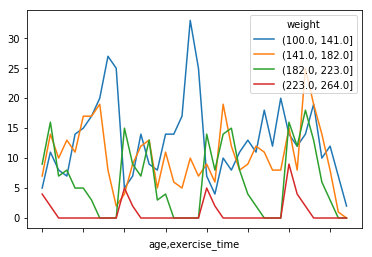

In [65]:
#Finally, a visual representation.
ct.plot();



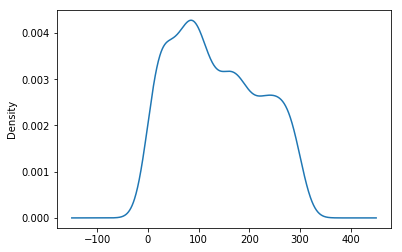

In [66]:
persons['exercise_time'].plot.density();
# Probably not the best representation

In [0]:
ct = pd.crosstab(time_bins2, [age_bins, weight_bins], normalize='columns')

In [0]:
ct_final = ct.iloc[:, [2,3]]

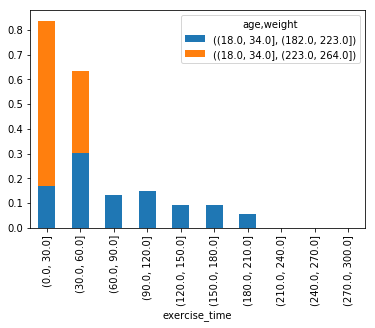

In [75]:
ct_final.plot(kind='bar', stacked=True)

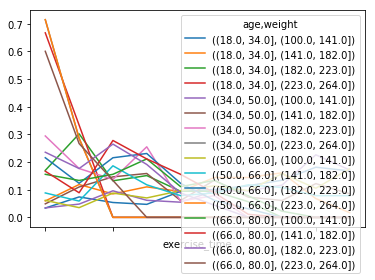

In [76]:
ct.plot()

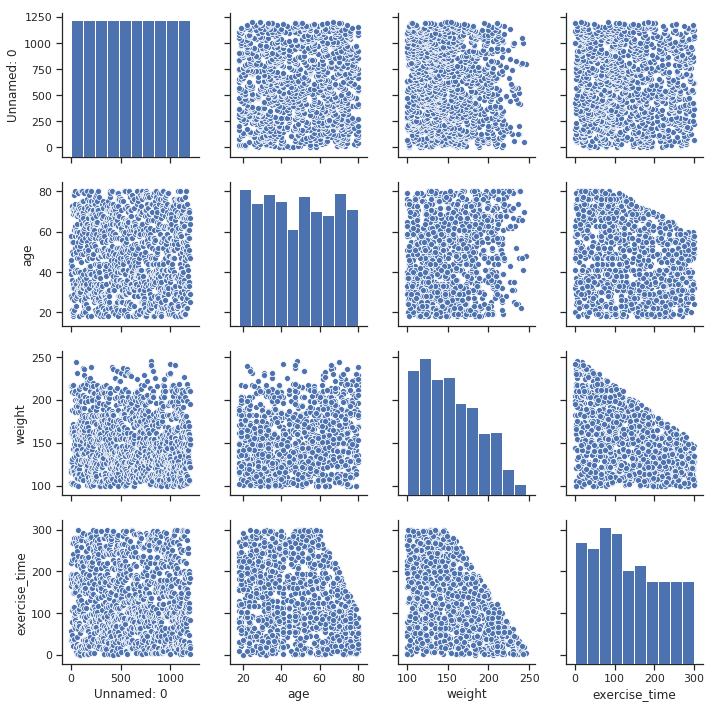

In [77]:
import seaborn as sns 

sns.set(style='ticks', color_codes=True)
graph = sns.pairplot(persons)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
**Integers, Continuous**
2.  What are the relationships between the variables?
**There is a correlation between all three variables.**
3.  Which relationships are "real", and which spurious?
**I believe all of the relationships are 'real.'**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)